In [61]:
import sys
sys.path.append('API')
from API import get_data_from_api, transform_api_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import numpy as np
plt.rcParams['figure.figsize'] = 16,9
plt.rcParams['font.size'] = 18

In [4]:
client = get_data_from_api.create_mong_client()
db = client['bda']
collection = db['bikes']

In [46]:
cityname = "Bonn"
city_uid = 547

In [47]:
r = db.bikes.aggregate([
      {"$unwind":"$countries"},
      {"$unwind":"$countries.cities"}, 
      {"$match":
       {"countries.cities.name": cityname,
        "countries.cities.uid": city_uid}
      },
      {'$project':{'countries.cities.places':1,'countries.cities.uid':1,'countries.cities.name':1,
      'countries.country_name':1,'timestamp':1}}
])

In [48]:
dfs = [pd.DataFrame(transform_api_data.add_timestamp_to_dict(r_t)) for r_t in r]
df = pd.concat(dfs)

df

,uid,lat,lng,bikes_available_to_rent,bike_racks,free_racks,special_racks,bike_numbers,name,booked_bikes,bikes,free_special_racks,timestamp,country_name,city_uid,city_name
0,10044279,50.739211,7.126598,0,0,0,0,[],Bahnhof Beuel,0,0,0,1970-01-01 00:00:00.000,Germany,547,Bonn
1,10044287,50.736768,7.080957,1,0,0,0,[45196],Haltepunkt Bonn-West,0,1,0,1970-01-01 00:00:00.000,Germany,547,Bonn
2,10044296,50.714610,7.160082,1,0,0,0,[45084],Bahnhof Oberkassel,0,1,0,1970-01-01 00:00:00.000,Germany,547,Bonn
3,10044315,50.717880,7.125460,0,0,0,0,[],Bundeshaus,0,0,0,1970-01-01 00:00:00.000,Germany,547,Bonn
4,10044322,50.717570,7.090974,0,0,0,0,[],St. Marien Hospital,0,0,0,1970-01-01 00:00:00.000,Germany,547,Bonn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,139269439,50.744529,7.096144,1,0,0,0,[44817],BIKE 44817,0,1,0,2023-01-03 23:00:06.647,Germany,547,Bonn
711,139269446,50.693733,7.127874,1,0,0,0,[44581],BIKE 44581,0,1,0,2023-01-03 23:00:06.647,Germany,547,Bonn
712,139269452,50.740511,7.085824,1,0,0,0,[45436],BIKE 45436,0,1,0,2023-01-03 23:00:06.647,Germany,547,Bonn
713,139269494,50.695836,7.184618,1,0,0,0,[45080],BIKE 45080,0,1,0,2023-01-03 23:00:06.647,Germany,547,Bonn


In [49]:
stations = df.uid.value_counts()[df.uid.value_counts()==len(dfs)].index
df = df.loc[df['uid'].isin(stations)]
df = transform_api_data.add_related_columns(df)

In [50]:
x = df.apply(transform_api_data.calculate_usage, axis=1, result_type='expand')

In [51]:
x.head()

,timestamp_start,timestamp_end,uid,city_uid,city_name,country_name,lat,lng,returned,collected,valid
0,1970-01-01 00:00:00.000,1970-01-01 00:00:00.000,10044279,547,Bonn,Germany,50.739211,7.126598,-1,-1,False
1,1970-01-01 00:00:00.000,2022-12-18 18:23:05.639,10044279,547,Bonn,Germany,50.739211,7.126598,0,0,False
2,2022-12-18 18:23:05.639,2022-12-19 09:24:06.679,10044279,547,Bonn,Germany,50.739211,7.126598,0,0,False
3,2022-12-19 09:24:06.679,2022-12-19 09:25:04.184,10044279,547,Bonn,Germany,50.739211,7.126598,0,0,True
4,2022-12-19 09:25:04.184,2022-12-19 09:26:04.976,10044279,547,Bonn,Germany,50.739211,7.126598,0,0,True


# City - Bonn
```
- the analysis was performed for the city Bonn
- we can see the pick around 11 - the data were collected throut the Christmas. Therefore, many people dont go to work. 
    11 is an hour, when is warmer and people can go for a ride
- the smaller pick around 16 may be caused by people who work. 
- the explanantion, why there is no pick around 7 (it was a pick in historic data) may be caused by tempreture and the late sunrise.
```


In [55]:
city = 'Bonn'

In [57]:
agg_x = x.loc[(x.valid), :].groupby('timestamp_start').aggregate({'returned': 'sum', 'collected': 'sum'})

In [58]:
agg_x = agg_x.reset_index() 
agg_x['hour'] = agg_x['timestamp_start'].apply(lambda x: x.hour)

In [62]:
agg_hour = agg_x.groupby('hour').agg({'collected':np.mean})
agg_hour = agg_hour.reset_index()

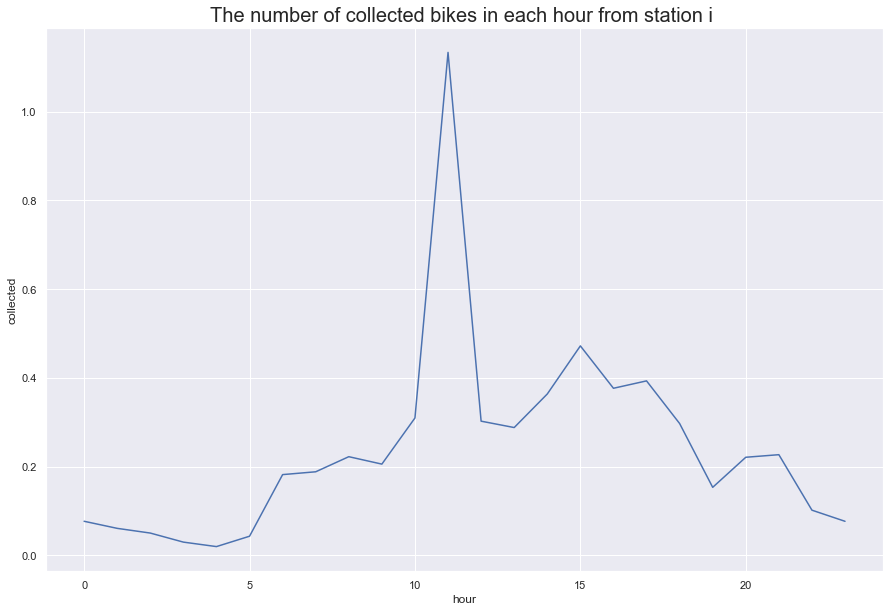

In [63]:
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")
g = sns.lineplot(data = agg_hour,x ='hour',y = 'collected',palette="tab10")
g.axes.set_title(label = f"The number of collected bikes in each hour from station i ",
fontsize = 20)
plt.show()